# K-means clustering with Python in Apache Spark

In [4]:
%ls data

sales_segments.csv.gz


In [5]:
import gzip

In [6]:
f = gzip.GzipFile('data/sales_segments.csv.gz')

In [7]:
type(f)

gzip.GzipFile

In [8]:
import pandas as pd

In [11]:
#como ya lo he ejecutado antes, he consumido el iterador. Debo volver a declararlo
f = gzip.GzipFile('data/sales_segments.csv.gz')

In [12]:
df = pd.read_csv(f, sep = '^')

/usr/lib64/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (40,44,45,47,48,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [13]:
df.head()

,rloc,departure_date_seg,booking_date,freq_flyer_flag,creator_office_id,creator_iata_number,creator_gds_code,creator_city_code,creator_lat,creator_lon,...,bookings_seg,rpk_seg,revenue_amount_seg,currency_code,fuel_surcharge_amount_seg,fuel_surcharge_currency_code,emd_count,emd_amount,emd_currency_code,total_outliers
0,59GS9Y,2013-12-21,2013-09-05,False,RUNHS3103,66200201,1A,RUN,-20.90083,55.53715,...,1,239,33.56,EUR,7.30,EUR,0,0,NaN,7.300000
1,4D87YU,2013-12-29,2013-01-29,False,RUNUU000B,66490104,UU,RUN,-20.90083,55.53715,...,5,1116,306.00,EUR,127.50,EUR,0,0,NaN,77.271017
2,7W67K8,2013-12-29,2013-02-05,False,RUNUU01A3,66490830,UU,RUN,-20.90083,55.53715,...,19,4240,1365.50,EUR,234.00,EUR,0,0,NaN,278.175661
3,3ESPWM,2013-12-29,2013-03-19,False,RUNUU010C,66490771,UU,RUN,-20.90083,55.53715,...,3,1220,81.35,EUR,39.93,EUR,0,0,NaN,32.458243
4,6ITPJM,2013-12-29,2013-05-11,False,MRSA12108,20261721,1A,MRS,43.29695,5.38107,...,2,1342,0.00,EUR,31.82,EUR,0,0,NaN,32.496507


In [16]:
df.size

86088139

In [15]:
df.columns

Index([u'rloc', u'departure_date_seg', u'booking_date', u'freq_flyer_flag',
       u'creator_office_id', u'creator_iata_number', u'creator_gds_code',
       u'creator_city_code', u'creator_lat', u'creator_lon',
       u'creator_country_code', u'creator_continent_code',
       u'creator_channel_code', u'booking_status_code', u'cabin_code',
       u'booking_class_code', u'pos_office_id', u'pos_iata_number',
       u'pos_gds_code', u'pos_city_code', u'pos_lat', u'pos_lon',
       u'pos_country_code', u'pos_continent_code', u'pos_channel_code',
       u'board_point_seg', u'board_lat', u'board_lon', u'board_country_code',
       u'board_continent_code', u'off_point_seg', u'off_lat', u'off_lon',
       u'off_country_code', u'off_continent_code', u'num_legs',
       u'distance_seg', u'route', u'network', u'airline_code',
       u'flight_number', u'flight_type', u'revenue_source', u'estimated_flag',
       u'usage_board_point_seg', u'usage_off_point_seg',
       u'usage_flight_number', u'usage

In [17]:
df.count()

rloc                            1459121
departure_date_seg              1459121
booking_date                    1459121
freq_flyer_flag                 1459121
creator_office_id               1459121
creator_iata_number             1414716
creator_gds_code                1459121
creator_city_code               1459121
creator_lat                     1459121
creator_lon                     1459121
creator_country_code            1459103
creator_continent_code          1459121
creator_channel_code            1454248
booking_status_code             1458491
cabin_code                      1459121
booking_class_code              1459121
pos_office_id                   1455702
pos_iata_number                 1455702
pos_gds_code                    1455702
pos_city_code                   1448816
pos_lat                         1448816
pos_lon                         1448816
pos_country_code                1448798
pos_continent_code              1448816
pos_channel_code                1455216


#### Vamos a ver outliers dentro de los precios, debido a supuestas incoherencias entre precios y tasas

In [22]:
df = df[['bookings_seg', 'revenue_amount_seg', 'fuel_surcharge_amount_seg']]

In [23]:
#vamos a intentar descubrir casos como el 4
df.head()

,bookings_seg,revenue_amount_seg,fuel_surcharge_amount_seg
0,1,33.56,7.30
1,5,306.00,127.50
2,19,1365.50,234.00
3,3,81.35,39.93
4,2,0.00,31.82


In [25]:
df['revenue'] = df['revenue_amount_seg'] / df['bookings_seg']

In [26]:
df.head()

,bookings_seg,revenue_amount_seg,fuel_surcharge_amount_seg,revenue
0,1,33.56,7.30,33.560000
1,5,306.00,127.50,61.200000
2,19,1365.50,234.00,71.868421
3,3,81.35,39.93,27.116667
4,2,0.00,31.82,0.000000


In [27]:
df['tax'] = df['fuel_surcharge_amount_seg'] / df['bookings_seg']

In [28]:
df.head()

,bookings_seg,revenue_amount_seg,fuel_surcharge_amount_seg,revenue,tax
0,1,33.56,7.30,33.560000,7.300000
1,5,306.00,127.50,61.200000,25.500000
2,19,1365.50,234.00,71.868421,12.315789
3,3,81.35,39.93,27.116667,13.310000
4,2,0.00,31.82,0.000000,15.910000


In [30]:
simple = df[['revenue', 'tax']]

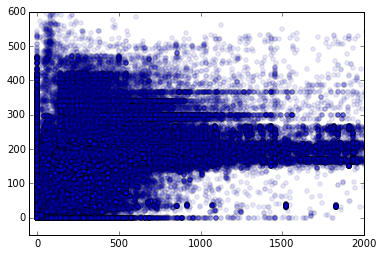

In [39]:
#f, ax = plt.subplot(figsize=(0,5))

plt.scatter(simple['revenue'], simple['tax'], alpha=0.1)
plt.xlim(-50,2000)
plt.ylim(-50,600)
plt.show()




In [40]:
smaller = simple.sample(10000)

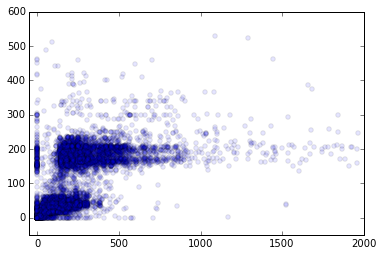

In [41]:
plt.scatter(smaller['revenue'], smaller['tax'], alpha=0.1)
plt.xlim(-50,2000)
plt.ylim(-50,600)
plt.show()

In [43]:
from sklearn.cluster import KMeans

In [44]:
import numpy as np

In [46]:
kmeans = KMeans(n_clusters=10)

In [47]:
clusters = kmeans.fit_predict(smaller)

In [48]:
clusters

array([4, 0, 0, ..., 0, 0, 3], dtype=int32)

In [49]:
#smaller.iloc[0] es el primer punto, está en el cluster 4 (según el resultado del array:
#array([4, 0, 0, ..., 0, 0, 3], dtype=int32)
smaller.iloc[0]

revenue    318.10
tax         87.43
Name: 509552, dtype: float64

In [50]:
smaller['cluster'] = clusters 

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [51]:
smaller

,revenue,tax,cluster
509552,318.100000,87.430000,4
544787,0.000000,24.970000,0
659451,111.850000,24.490000,0
958165,55.170000,9.675000,0
1124810,18.110000,0.000000,0
95589,366.890000,196.390000,4
532092,35.610000,17.960000,0
570578,0.000000,178.680000,0
815291,176.820000,224.140000,9
355571,541.830000,116.795000,2


In [53]:
groups = smaller.groupby(['cluster'])

In [55]:
means = groups.mean()

In [60]:
stdevs = groups.std()

In [69]:
#apaño temporal ya que algunos de los cluster daban sd = Nan
stdevs = stdevs.fillna(0.0001)

In [65]:
#vamos a renombrar la columna
means.columns = means.columns.map(lambda s : s + '_mean')

In [66]:
means.head(3)

,revenue_mean,tax_mean
cluster,,
0,58.821869,25.063538
1,214883.290000,29.730000
2,483.221219,188.915041


In [70]:
#vamos a renombrar la columna
stdevs.columns = stdevs.columns.map(lambda s : s + '_stdev')

In [73]:
cluster_stats = pd.merge(means, stdevs, left_index=True, right_index=True)

In [74]:
cluster_stats

,revenue_mean,tax_mean,revenue_stdev_stdev,tax_stdev_stdev
cluster,,,,
0,58.821869,25.063538,34.760200,25.077254
1,214883.290000,29.730000,0.000100,0.000100
2,483.221219,188.915041,60.704558,48.698322
3,1331.466163,215.068430,187.448081,80.335445
4,304.931967,181.442708,45.508219,42.200591
5,6395.990000,207.190000,0.000100,0.000100
6,773.678307,205.056864,110.170303,57.430113
7,205.201417,40.878951,52.281328,18.719441
8,2036.111471,203.531176,301.587880,39.375342


In [76]:
#tenemos que transformar el index en una columna para hacer el join
cluster_stats = cluster_stats.reset_index()

In [77]:
cluster_stats

,cluster,revenue_mean,tax_mean,revenue_stdev_stdev,tax_stdev_stdev
0,0,58.821869,25.063538,34.760200,25.077254
1,1,214883.290000,29.730000,0.000100,0.000100
2,2,483.221219,188.915041,60.704558,48.698322
3,3,1331.466163,215.068430,187.448081,80.335445
4,4,304.931967,181.442708,45.508219,42.200591
5,5,6395.990000,207.190000,0.000100,0.000100
6,6,773.678307,205.056864,110.170303,57.430113
7,7,205.201417,40.878951,52.281328,18.719441
8,8,2036.111471,203.531176,301.587880,39.375342
9,9,167.493654,188.171249,50.503858,42.920531


In [78]:
merged = pd.merge(smaller, cluster_stats, left_on='cluster', right_on='cluster')

In [79]:
merged.head()

,revenue,tax,cluster,revenue_mean,tax_mean,revenue_stdev_stdev,tax_stdev_stdev
0,318.100000,87.43,4,304.931967,181.442708,45.508219,42.200591
1,366.890000,196.39,4,304.931967,181.442708,45.508219,42.200591
2,267.886667,207.19,4,304.931967,181.442708,45.508219,42.200591
3,320.030000,193.11,4,304.931967,181.442708,45.508219,42.200591
4,242.230000,220.97,4,304.931967,181.442708,45.508219,42.200591


In [80]:
#prototipo de la función
def get_z(row):
    return type(row)

merged.apply(get_z, axis=1)

0       <property object at 0x7f62e5d6ec58>
1       <property object at 0x7f62e5d6ec58>
2       <property object at 0x7f62e5d6ec58>
3       <property object at 0x7f62e5d6ec58>
4       <property object at 0x7f62e5d6ec58>
5       <property object at 0x7f62e5d6ec58>
6       <property object at 0x7f62e5d6ec58>
7       <property object at 0x7f62e5d6ec58>
8       <property object at 0x7f62e5d6ec58>
9       <property object at 0x7f62e5d6ec58>
10      <property object at 0x7f62e5d6ec58>
11      <property object at 0x7f62e5d6ec58>
12      <property object at 0x7f62e5d6ec58>
13      <property object at 0x7f62e5d6ec58>
14      <property object at 0x7f62e5d6ec58>
15      <property object at 0x7f62e5d6ec58>
16      <property object at 0x7f62e5d6ec58>
17      <property object at 0x7f62e5d6ec58>
18      <property object at 0x7f62e5d6ec58>
19      <property object at 0x7f62e5d6ec58>
20      <property object at 0x7f62e5d6ec58>
21      <property object at 0x7f62e5d6ec58>
22      <property object at 0x7f

In [84]:
from math import sqrt
def is_outlier(row):
    z_rev = ( row['revenue'] - row['revenue_mean'] ) / row ['revenue_stdev_stdev']
    z_tax = ( row['tax'] - row['tax_mean'] ) / row ['tax_stdev_stdev']
    #raiz cuadrada de la suma de los cuadrados
    z = sqrt(z_rev**2 + z_tax**2)
    #devuelve true o false si el z score es mayor que 3
    return z > 3

outlier = merged.apply(is_outlier, axis=1)

In [85]:
outlier.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [108]:
merged['outlier'] = outlier

In [109]:
merged.head()

,revenue,tax,cluster,revenue_mean,tax_mean,revenue_stdev_stdev,tax_stdev_stdev,outlier
0,318.100000,87.43,4,304.931967,181.442708,45.508219,42.200591,False
1,366.890000,196.39,4,304.931967,181.442708,45.508219,42.200591,False
2,267.886667,207.19,4,304.931967,181.442708,45.508219,42.200591,False
3,320.030000,193.11,4,304.931967,181.442708,45.508219,42.200591,False
4,242.230000,220.97,4,304.931967,181.442708,45.508219,42.200591,False


In [110]:
simple_oultiers = merged[['revenue', 'tax', 'outlier']]

In [111]:
simple_oultiers.head()

,revenue,tax,outlier
0,318.100000,87.43,False
1,366.890000,196.39,False
2,267.886667,207.19,False
3,320.030000,193.11,False
4,242.230000,220.97,False


TypeError: 'function' object has no attribute '__getitem__'

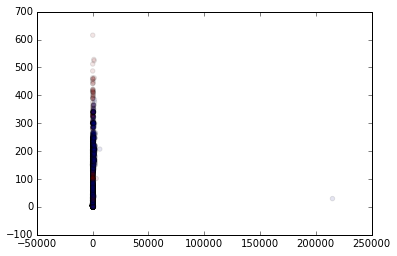

In [112]:
plt.scatter(simple_oultiers['revenue'], simple_oultiers['tax'], c=simple_oultiers['outlier'], alpha=0.1)
plt.xlim[-50,2000]
plt.ylim[-50,600]
plt.show()

In [101]:
simple_oultiers['revenue']

0          318.100000
1          366.890000
2          267.886667
3          320.030000
4          242.230000
5          252.000000
6          296.330000
7          298.450000
8          325.500000
9          280.990000
10         368.170000
11         285.640000
12         279.650000
13         310.960000
14         386.920000
15         345.150000
16         354.000000
17         310.990000
18         262.900000
19         339.990000
20         336.210000
21         306.000000
22         264.330000
23         255.490000
24         397.400000
25         252.210000
26         373.705000
27         380.990000
28         239.530000
29         383.265000
            ...      
9970      1086.000000
9971      1302.490000
9972      1081.000000
9973      1534.990000
9974      1091.000000
9975      1569.120000
9976      1401.560000
9977      1600.380000
9978      1525.000000
9979      1347.000000
9980      1461.020000
9981      1311.500000
9982      1407.950000
9983      1100.990000
9984      